# Minimal Dog Breeds Kaggle Competition -- fast.ai

## Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/dogbreed/"
image_size=224
arch=resnext101_64
batch_size=64

In [5]:
label_csv = f'{PATH}labels.csv'
num_labels = len(list(open(label_csv)))-1

In [6]:
# create a set of validation indices (i.e. indices not used for training -- by default it gets 20% of total for validation)
val_idxs = get_cv_idxs(num_labels)

## Initial Model

In [7]:
# changed num_workers to 8 to match num GPUs?
def get_data(arch, image_size, batch_size):
    tfms = tfms_from_model(arch, image_size, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test', num_workers=8,
                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=batch_size)
    return data if image_size > 300 else data.resize(340, 'tmp')

In [8]:
data = get_data(arch, image_size, batch_size)
learn_rate = 1e-1

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

### Precompute

In [85]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

# FIMXE: This is to keep track of weird initialization to get learn.predict_array() to work properly -- see "Weirdness" below
is_predict_initialized = False

In [86]:
learn.fit(learn_rate, 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.690007   0.379039   0.887109  
    1      0.383536   0.341999   0.899805                    
    2      0.284122   0.354853   0.905143                    
    3      0.196173   0.405926   0.910026                    



[0.40592557, 0.910026041790843]

### Try to predict breed of single dog image

In [87]:
learn.precompute = False

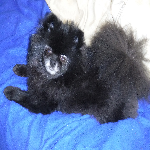

In [88]:
fn = "UrsaMinorThePomeranian.jpg"
#fn = data.val_ds.fnames[0]; print(fn)
#fn = "train/24f0dfc7352681f4572fe72514c5095c.jpg"
im = Image.open(PATH+fn).resize((150,150)); im

In [89]:
trn_tfms,val_tfms = tfms_from_model(arch, image_size)
tfim = val_tfms(np.array(im))

### Weirdness
### {

For some reason, in order to get a correct prediction with learn.predict_array(), 
we first have to make sure learn.precompute = False, then make a call to learn.predict_array(), 
then call learn.predict(). 

Otherwise we seem to get bogus results???

In [90]:
# FIXME: how do 
if (not is_predict_initialized) :
    single_image_preds = learn.predict_array(tfim[None])[0]
    learn.precompute = False
    log_preds = learn.predict()
    
    # only need to do this once!
    is_predict_initialized = True

### }
### End of Weirdness

In [91]:
single_image_preds = learn.predict_array(tfim[None])[0]

In [92]:
# Get an array of indices of the 5 highest matches, best matches first
sorted_idx = (np.argsort(single_image_preds))[::-1][:5]

In [94]:
# print best matches
for i in sorted_idx :
    print("{1:2.2f}%: {0:s} ".format(learn.data.classes[i], np.exp(single_image_preds[i])*100.0))

97.42%: pomeranian 
0.95%: pekinese 
0.80%: newfoundland 
0.33%: affenpinscher 
0.20%: japanese_spaniel 
